# Classifiers
****
We will look at first using a classifier to attempt to classify logerror as a series of bins, then within each bin, use a regression. This notebook will be mainly for finding the right classifier/parameters for our binning system.

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import sklearn

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
Housing = pd.read_csv('cleaned_1.csv')
Housing = Housing.set_index(['parcelid','Unnamed: 0'])
Housing['transactiondate'] = pd.to_datetime(Housing['transactiondate'], 
                                                 format = '%Y-%m-%d', errors = 'coerce')
Housing['taxamount'] = Housing['taxamount']*100
#Housing.info()

First we want to find which of the features are the most influential

[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[11:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned no

[11:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[11:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[11:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[11:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[11:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[11:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8


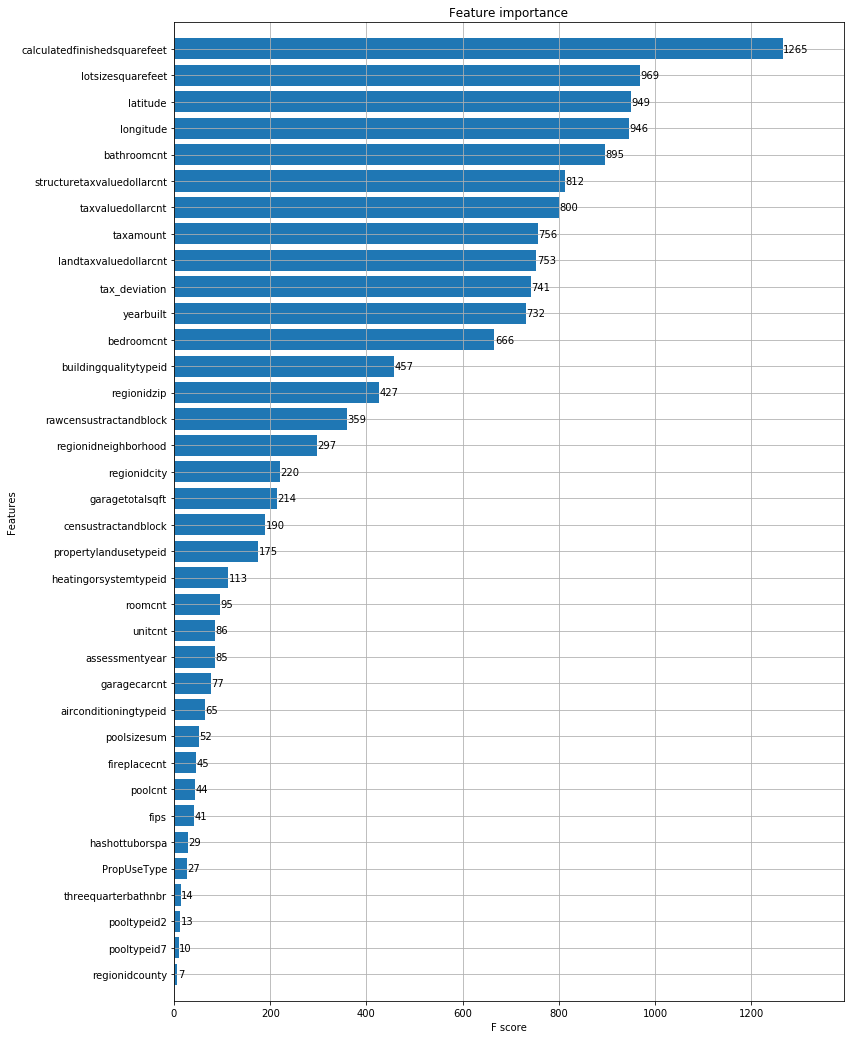

In [3]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

train_y = Housing['logerror'].values
df_train = Housing.drop(['logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'],
                        axis=1)
feat_names = df_train.columns.values

for c in df_train.columns:
    if df_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

We want to bin logerror for our classifier. So we will look at the following histogram to figure out what our bins should be.

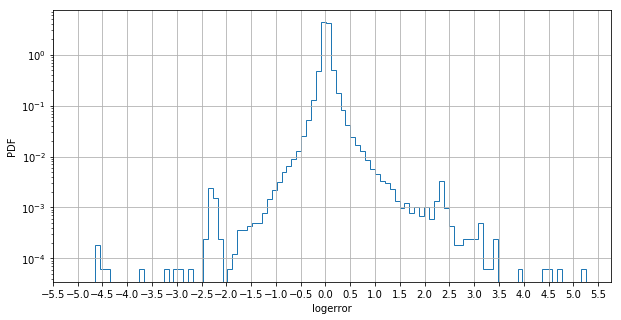

In [4]:
x=[-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5]

plt.figure(figsize = (10,5))
plt.hist(Housing['logerror'], bins=100, density=True, histtype='step')
plt.yscale('log')
plt.xlabel('logerror')
plt.xticks(x)
plt.ylabel('PDF')
plt.grid(True)

In [5]:
bins = [-5.5,-2,-0.2,0.2,0.75,2,5.5]
Housing['binned'] = pd.cut(Housing['logerror'], bins = bins, labels= bins[1:])
Housing['binned'].value_counts()

 0.20    155882
 0.75      5880
-0.20      3859
 2.00       664
 5.50       164
-2.00        83
Name: binned, dtype: int64

In [6]:
imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
         'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
         'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
         'regionidneighborhood']#,'tax_deviation'
# Save tax_deviation for regression

X_df = Housing[imp_cols].astype(int)
Y_df = Housing['binned'].cat.codes
Y_df.head()

parcelid  Unnamed: 0
17073783  0             2
17088994  1             2
17100444  2             2
17102429  3             2
17109604  4             2
dtype: int8

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, random_state = 5)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)
accuracy = clf.score(X_test, y_test)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.93


The problem with this dataset for classifiers is the abundance of values in the central bin. In order to accound for this we will need to do some sampling.
****

## Sampling

We will use a combination of smote and tomek under and over sampling to ensure that our bins are roughly the same size.

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [9]:
smt = SMOTETomek(ratio='auto', n_jobs = 4)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

print(len(y_smt))
np.unique(y_smt, return_counts = True)

/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


698608


(array([0, 1, 2, 3, 4, 5], dtype=int8),
 array([116881, 116446, 115609, 115941, 116855, 116876]))

In [10]:
clf.fit(X_smt, y_smt)

y_score = clf.predict_proba(X_test)
accuracy = clf.score(X_test, y_test)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.90


So we have a proof of concept for a classifier. Now lets look for the best one.
****
## Random Forests

In [11]:
samples = [5,10,50]
features = [3,5,10]

###### Note, best performance at 100 samples, 3 features.
###### Or, at 10 samples, 3 features
refined_samples = [10]
refined_features = [3]

for i in samples:
    for j in features:
        clf = RandomForestClassifier(n_estimators = i, max_features = j, random_state = 5)
        clf.fit(X_smt, y_smt)
        print('samples: ', i, ', features: ', j)
        print('Accuracy of RF classifier on training set: {:.2f}'.format(clf.score(X_smt, y_smt)))
        print('Accuracy of RF classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))
        print('')

samples:  5 , features:  3
Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.73

samples:  5 , features:  5
Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.74

samples:  5 , features:  10
Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.75

samples:  10 , features:  3
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.76

samples:  10 , features:  5
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.77

samples:  10 , features:  10
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.78

samples:  50 , features:  3
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80

samples:  50 , features:  5
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80

samples:  50 , features:  10
Accu

### Gradiant boosting

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
clf_boost = GradientBoostingClassifier().fit(X_smt, y_smt)

print('learning_rate=0.1, max_depth=3')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf_boost.score(X_smt, y_smt)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf_boost.score(X_test, y_test)))

clf_boost = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 5)
clf_boost.fit(X_smt, y_smt)

print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf_boost.score(X_smt, y_smt)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf_boost.score(X_test, y_test)))

learning_rate=0.1, max_depth=3
Accuracy of GBDT classifier on training set: 0.66
Accuracy of GBDT classifier on test set: 0.89
(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.42
Accuracy of GBDT classifier on test set: 0.50


In [12]:
learning_rates = [0.01, 0.05, 0.1]
depths = [2,3,5]

#best performance at 0.1 rate, depth 5 for 0.5 width

for i in learning_rates:
    for j in depths:
        clf_boost = GradientBoostingClassifier(learning_rate = i, max_depth = j, random_state = 5)
        clf_boost.fit(X_smt, y_smt)

        print('rate: ', i, ' depth: ',j)
        print('Accuracy of GBDT classifier on training set: {:.2f}'.format(clf_boost.score(X_smt, y_smt)))
        print('Accuracy of GBDT classifier on test set: {:.2f}'.format(clf_boost.score(X_test, y_test)))
        print('-')

rate:  0.01  depth:  2
Accuracy of GBDT classifier on training set: 0.42
Accuracy of GBDT classifier on test set: 0.50
-
rate:  0.01  depth:  3
Accuracy of GBDT classifier on training set: 0.47
Accuracy of GBDT classifier on test set: 0.56
-
rate:  0.01  depth:  5
Accuracy of GBDT classifier on training set: 0.61
Accuracy of GBDT classifier on test set: 0.82
-
rate:  0.05  depth:  2
Accuracy of GBDT classifier on training set: 0.52
Accuracy of GBDT classifier on test set: 0.81
-
rate:  0.05  depth:  3
Accuracy of GBDT classifier on training set: 0.60
Accuracy of GBDT classifier on test set: 0.87
-
rate:  0.05  depth:  5
Accuracy of GBDT classifier on training set: 0.75
Accuracy of GBDT classifier on test set: 0.90
-
rate:  0.1  depth:  2
Accuracy of GBDT classifier on training set: 0.57
Accuracy of GBDT classifier on test set: 0.87
-
rate:  0.1  depth:  3
Accuracy of GBDT classifier on training set: 0.66
Accuracy of GBDT classifier on test set: 0.89
-
rate:  0.1  depth:  5
Accuracy of 

### Neural Network classifier

In [14]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_smt)
X_test_scaled = scaler.transform(X_test)

clf_NN = MLPClassifier(hidden_layer_sizes = [10, 10], alpha = 0.01,
                       random_state = 5, solver='lbfgs').fit(X_train_scaled, y_smt)


print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf_NN.score(X_train_scaled, y_smt)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf_NN.score(X_test_scaled, y_test)))

Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.17


## Choices
****
The accuracy of most of these models depends heavily on the choices of bins, specifically when 0 divides the most common bins. However, all the models perform fairly similarly, but below we note that gradiant boosting and neural networks are just guessing everything as the class containing 0. But random forests achieve similar scores while making varied guesses. So the random forest parameter we will chose is n_estimators = 100, max_features = 3.

In [13]:
np.unique(clf_boost.predict(X_test))

array([2], dtype=int8)

In [14]:
np.unique(clf_NN.predict(X_test))

array([2], dtype=int8)

In [18]:
clf_100 = RandomForestClassifier(n_estimators = 100, max_features = 3, bootstrap = True, random_state = 5)
clf_100.fit(X_train, y_train)

print(np.unique(clf_100.predict(X_test)))
print(clf_100.score(X_test, y_test))

[0 1 2 3 4 5]
0.8372204741431076


In [19]:
clf_10 = RandomForestClassifier(n_estimators = 10, max_features = 3, bootstrap = True, random_state = 5)
clf_10.fit(X_train, y_train)

print(np.unique(clf_10.predict(X_test)))
print(clf_10.score(X_test, y_test))

[0 1 2 3 4 5]
0.8268921288401028


In [23]:
clf_100.predict(X_test)

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)